In [59]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import get_close_matches

In [2]:
# fixes issue with autocomplete and pandas
%config Completer.use_jedi = False

In [ ]:
# For each player
# get total points, total active points, total points for drafter
# get n games so you can convert those to ppg (address injuries)

# Radius function
# given a pick radius and a points type
# what was the difference that player got in points from the
# average in their radius

# Drafted rank vs actual rank

In [22]:
draft = pandas.read_csv('DraftOrder.csv',index_col=0)
player = pandas.read_csv('TPlayer.csv')

In [11]:
draft.head()

,round,pick,player,team,info,overall,unique_str
0,1.0,1.0,Christian McCaffrey,The Longest Yard,RB - CAR,1,"McCaffrey, C. RB CAR"
1,1.0,2.0,Saquon Barkley,Tight Ends Spread Sheets,RB - NYG,2,"Barkley, S. RB NYG"
2,1.0,3.0,Ezekiel Elliott,Eatin W's,RB - DAL,3,"Elliott, E. RB DAL"
3,1.0,4.0,Alvin Kamara,ganggreen215,RB - NO,4,"Kamara, A. RB NO"
4,1.0,5.0,Dalvin Cook,Gronk's New Groove,RB - MIN,5,"Cook, D. RB MIN"


In [12]:
player.index = player.unique_str.values

In [14]:
draft.iloc[0]['unique_str']

'McCaffrey, C. RB CAR'

#### ID and deal with non-matches between datasets

In [28]:
all_players = player.unique_str.unique()
for i,row in draft.iterrows():
    if row['unique_str'] not in player['unique_str'].values:
        print(row['player'],i,'not found')
        matches = get_close_matches(row['unique_str'],all_players)
        print('any of these look good?')
        print(matches,'\n')

Odell Beckham Jr. 36 not found
any of these look good?
['Beckham, O. WR CLE', 'Landry, J. WR CLE'] 

Henry Ruggs III 101 not found
any of these look good?
['Ruggs, H. WR LV', 'Renfrow, H. WR LV'] 

Marlon Mack 105 not found
any of these look good?
['Taylor, J. RB IND', 'Gaskin, M. RB MIA', 'Pittman, M. WR IND'] 

Larry Fitzgerald 153 not found
any of these look good?
['Kirk, C. WR ARI', 'Shenault, L. WR JAX'] 



In [29]:
draft.loc[36,'unique_str'] = 'Beckham, O. WR CLE'
draft.loc[101,'unique_str'] = 'Ruggs, H. WR LV'

What happened to Larry and Marlon??

In [32]:
trans = pandas.read_csv('TransactionTable.csv')

In [36]:
# whoops. I guess that's automatically 0 points for me at pick 153!
trans[trans.Player=='Larry Fitzgerald']

,Date,Week,TransType,Player,Position,Team,From,To,By,TransCosts
37,2020-09-10 10:50:00,1,Drop,Larry Fitzgerald,WR,ARI,The Wet Market Pangolins,Waivers,Jake,NaN


In [37]:
# oof -- even worse for Matt at pick 105!
trans[trans.Player=='Marlon Mack']

,Date,Week,TransType,Player,Position,Team,From,To,By,TransCosts
91,2020-09-14 08:36:00,1,Drop,Marlon Mack,RB,IND,Do it for George,Waivers,Matt,NaN


We will need to add in a zeroing exception specifically for these two players

In [38]:
exceptions = ['Marlon Mack','Larry Fitzgerald']

## Collect player points

In [51]:
team_table = {'The Longest Yard':'Lucas','The Wet Market Pangolins':'Jake',
          "Gronk's New Groove":'Sam','Tight Ends Spread Sheets':'f',
          'Fantasy Football Team':'Liam',"Eatin W's":'Graham',
          'Do it for George':'Matt','Triple Crown':'Nolan',
          'KaepernicksRevenge':'Jess','ganggreen215':'Kevin'}

In [63]:
# get total points, total active points, total points for drafter
# get n games so you can convert those to ppg (address injuries)

for i,row in draft.iterrows():
    # deal with exceptions
    if row['player'] in exceptions:
        draft.loc[i,['ActivePoints','DrafterPoints',]] = 0
    else:
        pdf = player[player.unique_str==row['unique_str']]
        draft.loc[i,'TotalPoints'] = pdf.points.sum()
        draft.loc[i,'ActivePoints'] = pdf[pdf.status=='Active'
                                         ].points.sum()
        draft.loc[i,'DrafterPoints'] = pdf[
                    (pdf.status=='Active') & \
                    (pdf.owner==team_table[row['team']])
                                          ].points.sum()
        ## WARNING: Assumes 0 pt games = inactive (not always true)
        draft.loc[i,'Games'] = len(pdf[pdf.points!=0])
        draft.loc[i,'ActiveGames'] = len(pdf[(pdf.points!=0) &\
                                             (pdf.status=='Active')])

#### quick plotting break!

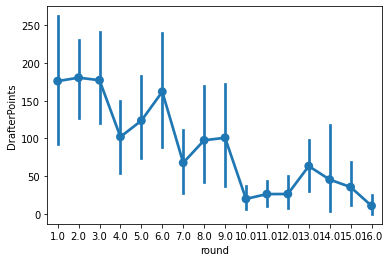

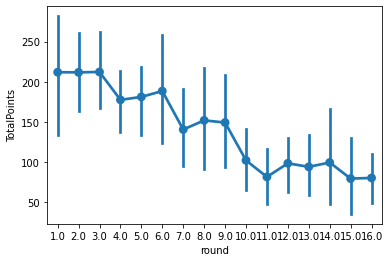

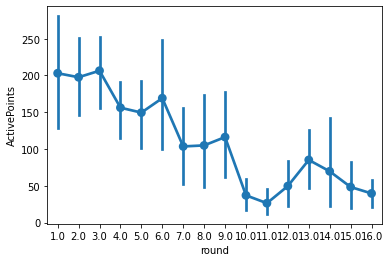

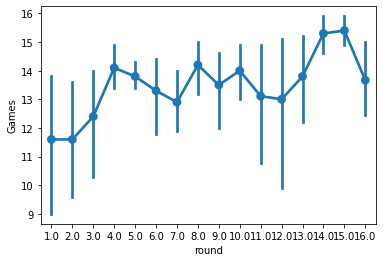

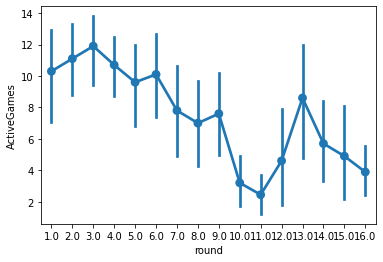

In [64]:
for col in draft.columns[-5:]:
    #sns.swarmplot(x='round',y=col,alpha=0.5,data=draft)
    #sns.boxplot(x='round',y=col,color='gray',data=draft)
    sns.pointplot(x='round',y=col,data=draft)
    plt.show()

### real quick base stats

#### Who got the most points out of the draft

In [70]:
draft.groupby('team')['DrafterPoints'].mean().sort_values(ascending=False)

team
ganggreen215                113.52625
KaepernicksRevenge          105.50375
Triple Crown                 92.61500
The Longest Yard             91.38500
The Wet Market Pangolins     88.81375
Eatin W's                    88.71625
Gronk's New Groove           85.14750
Fantasy Football Team        83.12375
Tight Ends Spread Sheets     72.02625
Do it for George             64.09750
Name: DrafterPoints, dtype: float64

#### Who did best on each draft stat?

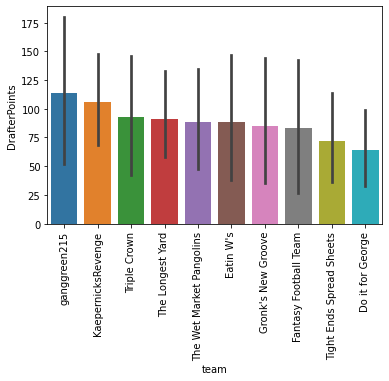

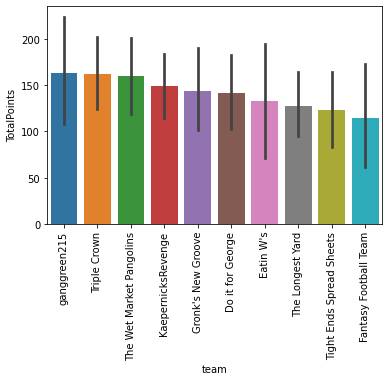

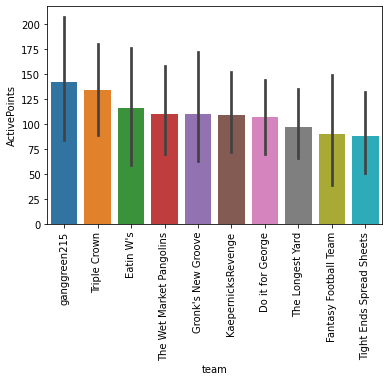

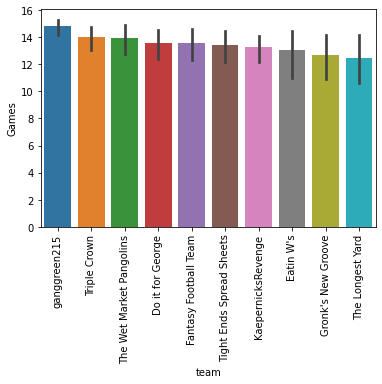

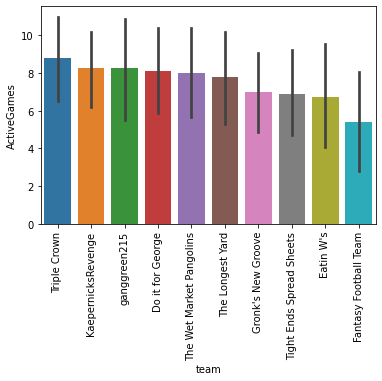

In [78]:
for col in draft.columns[-5:]:
    order = draft.groupby('team')[col
                                 ].mean().sort_values(ascending=False).index
    g = sns.barplot(x='team',y=col,data=draft,order=order)
    g.set_xticklabels(g.get_xticklabels(),rotation = 90)
    plt.show()

#### What was the average percent of total points that went to the teams that drafted them?

In [86]:
pandas.concat([draft.team,(draft.DrafterPoints / draft.TotalPoints)],
              axis=1).groupby('team').mean().sort_values(0,
                                                         ascending=False)

,0
team,
KaepernicksRevenge,0.639183
The Longest Yard,0.609724
The Wet Market Pangolins,0.548561
ganggreen215,0.545248
Tight Ends Spread Sheets,0.525403
Fantasy Football Team,0.471969
Do it for George,0.462419
Triple Crown,0.441337
Gronk's New Groove,0.432878


#### What was the average percent of active points that went to the teams that drafted them?

In [88]:
pandas.concat([draft.team,(draft.DrafterPoints / draft.ActivePoints)],
              axis=1).groupby('team').mean().sort_values(0,
                                                         ascending=False)

,0
team,
KaepernicksRevenge,0.903446
The Longest Yard,0.857143
Tight Ends Spread Sheets,0.821513
Fantasy Football Team,0.809737
The Wet Market Pangolins,0.759650
ganggreen215,0.640859
Eatin W's,0.637640
Do it for George,0.634360
Gronk's New Groove,0.625383


#### May be a less individually biased way of looking at that:

In [91]:
(draft.groupby('team')['DrafterPoints'].mean() \
        / draft.groupby('team')['ActivePoints'].mean()
).sort_values(ascending=False)

team
KaepernicksRevenge          0.969670
The Longest Yard            0.940199
Fantasy Football Team       0.928511
Tight Ends Spread Sheets    0.821678
The Wet Market Pangolins    0.805302
ganggreen215                0.797788
Gronk's New Groove          0.773998
Eatin W's                   0.767948
Triple Crown                0.694493
Do it for George            0.601445
dtype: float64

## Radius

In [92]:
def radial_differential(df,i,r,col):
    pick = df.loc[i,'overall']
    r1 = pick - r
    r2 = pick + r
    radius = df[(df['overall']>=r1) & (df['overall']<=r2)]
    mn = radius[col].mean()
    
    return df.loc[i,col] - mn

In [93]:
for i,row in draft.iterrows():
    diff = radial_differential(draft,i,3,'TotalPoints')
    draft.loc[i,'R3_TP_diff'] = diff
    diff = radial_differential(draft,i,3,'DrafterPoints')
    draft.loc[i,'R3_DP_diff'] = diff

#### Worst Overall Picks

In [95]:
draft.sort_values('R3_TP_diff').head(10)

,round,pick,player,team,info,overall,unique_str,DrafterPoints,TotalPoints,ActivePoints,Games,ActiveGames,R3_TP_diff,R3_DP_diff
1,1.0,2.0,Saquon Barkley,Tight Ends Spread Sheets,RB - NYG,2,"Barkley, S. RB NYG",15.4,15.4,15.4,8.0,2.0,-191.480000,-163.300000
6,1.0,7.0,Michael Thomas,The Wet Market Pangolins,WR - NO,7,"Thomas, M. WR NO",83.9,83.9,83.9,7.0,7.0,-173.800000,-142.842857
24,3.0,5.0,Kenny Golladay,Gronk's New Groove,WR - DET,25,"Golladay, K. WR DET",48.1,65.8,48.1,5.0,3.0,-158.400000,-127.928571
89,9.0,10.0,Jordan Howard,Fantasy Football Team,RB,90,"Howard, J. RB Free Agent",0.0,6.7,0.0,16.0,0.0,-130.777143,-86.791429
54,6.0,5.0,Marquise Brown,Do it for George,WR - BAL,55,"Brown, M. WR BAL",72.7,90.2,72.7,14.0,6.0,-129.562857,-117.868571
52,6.0,3.0,Mark Ingram,KaepernicksRevenge,RB - BAL,53,"Ingram, M. RB BAL",38.0,40.0,38.0,13.0,5.0,-128.482857,-122.611429
90,10.0,1.0,Tarik Cohen,Fantasy Football Team,RB - CHI,91,"Cohen, T. RB CHI",6.7,10.4,6.7,16.0,1.0,-127.762857,-81.134286
49,5.0,10.0,Courtland Sutton,Fantasy Football Team,WR - DEN,50,"Sutton, C. WR DEN",0.0,9.6,0.0,13.0,0.0,-123.971429,-114.171429
20,3.0,1.0,Chris Godwin,The Longest Yard,WR - TB,21,"Godwin, C. WR TB",149.1,160.7,149.1,11.0,9.0,-123.131429,-72.231429
62,7.0,3.0,Cam Akers,Eatin W's,RB - LA,63,"Akers, C. RB LA",0.0,19.9,7.2,11.0,1.0,-121.342857,-71.242857


In [96]:
draft.sort_values('R3_DP_diff').head(10)

,round,pick,player,team,info,overall,unique_str,DrafterPoints,TotalPoints,ActivePoints,Games,ActiveGames,R3_TP_diff,R3_DP_diff
21,3.0,2.0,Allen Robinson,Tight Ends Spread Sheets,WR - CHI,22,"Robinson, A. WR CHI",18.6,257.20,229.80,15.0,14.0,10.954286,-180.717143
15,2.0,6.0,Joe Mixon,Gronk's New Groove,RB - CIN,16,"Mixon, J. RB CIN",6.1,99.60,49.00,6.0,4.0,-107.451429,-165.265714
1,1.0,2.0,Saquon Barkley,Tight Ends Spread Sheets,RB - NYG,2,"Barkley, S. RB NYG",15.4,15.40,15.40,8.0,2.0,-191.480000,-163.300000
57,6.0,8.0,Jarvis Landry,Eatin W's,WR - CLE,58,"Landry, J. WR CLE",7.6,171.56,73.92,14.0,6.0,-17.020000,-145.728571
6,1.0,7.0,Michael Thomas,The Wet Market Pangolins,WR - NO,7,"Thomas, M. WR NO",83.9,83.90,83.90,7.0,7.0,-173.800000,-142.842857
8,1.0,9.0,Kenyan Drake,Triple Crown,RB - ARI,9,"Drake, K. RB ARI",34.9,184.10,145.20,14.0,11.0,-21.971429,-140.214286
24,3.0,5.0,Kenny Golladay,Gronk's New Groove,WR - DET,25,"Golladay, K. WR DET",48.1,65.80,48.10,5.0,3.0,-158.400000,-127.928571
52,6.0,3.0,Mark Ingram,KaepernicksRevenge,RB - BAL,53,"Ingram, M. RB BAL",38.0,40.00,38.00,13.0,5.0,-128.482857,-122.611429
54,6.0,5.0,Marquise Brown,Do it for George,WR - BAL,55,"Brown, M. WR BAL",72.7,90.20,72.70,14.0,6.0,-129.562857,-117.868571
71,8.0,2.0,Leonard Fournette,Triple Crown,RB - TB,72,"Fournette, L. RB TB",0.0,127.30,45.30,11.0,5.0,-60.188571,-116.385714


#### Best Overall Picks

In [97]:
draft.sort_values('R3_TP_diff').tail(10)

,round,pick,player,team,info,overall,unique_str,DrafterPoints,TotalPoints,ActivePoints,Games,ActiveGames,R3_TP_diff,R3_DP_diff
23,3.0,4.0,Patrick Mahomes,ganggreen215,QB - KC,24,"Mahomes, P. QB KC",374.40,374.40,374.40,15.0,15.0,155.300000,205.128571
141,15.0,2.0,Cam Newton,Tight Ends Spread Sheets,QB - NE,142,"Newton, C. QB NE",64.06,222.50,64.06,14.0,4.0,165.874286,41.294286
55,6.0,6.0,Kyler Murray,Gronk's New Groove,QB - ARI,56,"Murray, K. QB ARI",374.96,374.96,374.96,15.0,15.0,166.020000,195.214286
65,7.0,6.0,Stefon Diggs,Do it for George,WR - BUF,66,"Diggs, S. WR BUF",16.60,314.00,293.40,15.0,14.0,177.014286,-41.142857
70,8.0,1.0,Josh Allen,Fantasy Football Team,QB - BUF,71,"Allen, J. QB BUF",360.48,376.80,360.48,15.0,14.0,183.085714,243.968571
3,1.0,4.0,Alvin Kamara,ganggreen215,RB - NO,4,"Kamara, A. RB NO",382.20,382.20,382.20,15.0,15.0,197.300000,227.071429
88,9.0,9.0,Russell Wilson,Triple Crown,QB - SEA,89,"Wilson, R. QB SEA",341.64,341.64,341.64,15.0,15.0,210.234286,258.705714
137,14.0,8.0,Aaron Rodgers,Eatin W's,QB - GB,138,"Rodgers, A. QB GB",357.26,357.26,357.26,15.0,15.0,262.468571,300.408571
105,11.0,6.0,Marlon Mack,Do it for George,RB - IND,106,"Mack, M. RB IND",0.00,NaN,0.00,NaN,NaN,NaN,-22.922857
153,16.0,4.0,Larry Fitzgerald,The Wet Market Pangolins,WR - ARI,154,"Fitzgerald, L. WR ARI",0.00,NaN,0.00,NaN,NaN,NaN,-8.771429


In [98]:
draft.sort_values('R3_DP_diff').tail(10)

,round,pick,player,team,info,overall,unique_str,DrafterPoints,TotalPoints,ActivePoints,Games,ActiveGames,R3_TP_diff,R3_DP_diff
18,2.0,9.0,Travis Kelce,Tight Ends Spread Sheets,TE - KC,19,"Kelce, T. TE KC",312.76,312.76,312.76,15.0,15.0,63.042857,138.900000
51,6.0,2.0,DK Metcalf,Triple Crown,WR - SEA,52,"Metcalf, D. WR SEA",266.20,266.20,266.20,15.0,15.0,129.340000,145.311429
4,1.0,5.0,Dalvin Cook,Gronk's New Groove,RB - MIN,5,"Cook, D. RB MIN",337.80,337.80,337.80,14.0,14.0,123.228571,153.000000
9,1.0,10.0,Davante Adams,Fantasy Football Team,WR - GB,10,"Adams, D. WR GB",341.80,341.80,341.80,13.0,13.0,140.000000,161.314286
55,6.0,6.0,Kyler Murray,Gronk's New Groove,QB - ARI,56,"Murray, K. QB ARI",374.96,374.96,374.96,15.0,15.0,166.020000,195.214286
23,3.0,4.0,Patrick Mahomes,ganggreen215,QB - KC,24,"Mahomes, P. QB KC",374.40,374.40,374.40,15.0,15.0,155.300000,205.128571
3,1.0,4.0,Alvin Kamara,ganggreen215,RB - NO,4,"Kamara, A. RB NO",382.20,382.20,382.20,15.0,15.0,197.300000,227.071429
70,8.0,1.0,Josh Allen,Fantasy Football Team,QB - BUF,71,"Allen, J. QB BUF",360.48,376.80,360.48,15.0,14.0,183.085714,243.968571
88,9.0,9.0,Russell Wilson,Triple Crown,QB - SEA,89,"Wilson, R. QB SEA",341.64,341.64,341.64,15.0,15.0,210.234286,258.705714
137,14.0,8.0,Aaron Rodgers,Eatin W's,QB - GB,138,"Rodgers, A. QB GB",357.26,357.26,357.26,15.0,15.0,262.468571,300.408571


#### Who made the best picks on average?

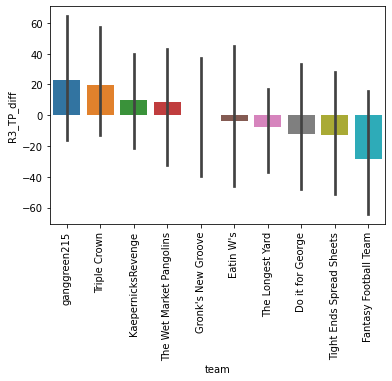

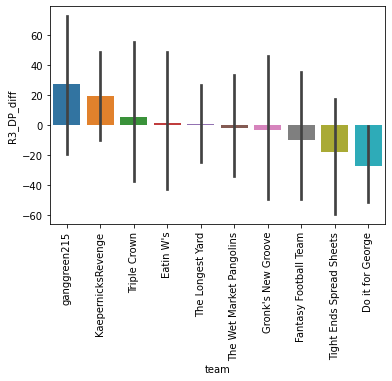

In [99]:
for col in draft.columns[-2:]:
    order = draft.groupby('team')[col
                                 ].mean().sort_values(ascending=False).index
    g = sns.barplot(x='team',y=col,data=draft,order=order)
    g.set_xticklabels(g.get_xticklabels(),rotation = 90)
    plt.show()